# 🔍 RAG-Based Chatbot for the University of Sheffield

## 📌 Overview

This project implements a **Retrieval-Augmented Generation (RAG)** chatbot designed to answer **research and computer science-related queries** about **the University of Sheffield**. The system integrates **hybrid document retrieval, reranking, and LLM-based answer generation and refinement** to deliver accurate, relevant, and well-formulated responses.

The chatbot is built using:
- **Hybrid retrieval** (BM25 + Chroma vector database)  
- **A reranker model** (FlagEmbedding-based) to improve retrieval results  
- **Llama 3.2 (3B parameter model, FP16)** for response generation and refinement
- **Gradio** for an interactive UI   

---

## How It Works

### **1️⃣ User Query Processing**
- The chatbot first checks if the question is a **general greeting or FAQ** (e.g., "Who are you?"). If so, it returns a **predefined response** without using retrieval.  
- If the question is **research-related**, the system searches for relevant documents in a **preprocessed knowledge base** (University of Sheffield research data).  

### **2️⃣ Document Retrieval and Reranking**
- The **retrieval pipeline** consists of:

  ✅ **BM25 (keyword-based search)** – for retrieving exact text matches  
  ✅ **Chroma (vector search)** – for semantic similarity matching  
  ✅ **Ensemble Retrieval** – combines BM25 & Chroma with equal weighting  
  ✅ **FlagReranker** – ranks documents by relevance, documents scoring below
   **< 0.2** are discarded to avoid hallucinations and answering irrelevant questions.

### **3️⃣ Answer Generation (LLM-Powered)**
- The retrieved documents are passed to **Llama 3.2 (3B-Instruct-FP16)**.  
- The chatbot is explicitly **instructed to only answer questions based on provided context**.  
- If no documents are retrieved, it provides a **fallback response**, ensuring it does not hallucinate answers.  

### **4️⃣ Answer refinement**
Once an initial answer is generated, a second pass with the LLM refines it to:
- Improve fluency, coherence, and structure
- Ensure the answer addresses the full scope of the question
- Correct any vague or incomplete parts
- Avoid including any unsupported information

This is done using a special prompt that:
- Checks the correctness of the answer
- Revises it using only the retrieved documents
- Returns a final polished version ready to display to the user


### **5️⃣ Gradio UI for User Interaction**
- **Gradio Chat Interface**: Users can type queries and receive responses in real time.  
- **Accordion Display**: Allows users to view retrieved documents used in generating responses.  
- **Streaming Response**: The chatbot outputs responses word-by-word for a more natural interaction.  

### **1️⃣ Install Dependencies**
```bash
!pip install -r /content/requirements.txt
```
### **2️⃣ Set API Key for Trivy web search - For Evaluation**
```bash
_set_env("TAVILY_API_KEY")
```
### **3️⃣ Download and Serve Llama 3.2(3B instruct fp16)**
```bash
!curl -fsSL https://ollama.com/install.sh | sh
!nohup ollama serve > /dev/null 2>&1 &
!ollama pull llama3.2:3b-instruct-fp16 > /dev/null 2>&1 &
```
### **4️⃣ Extract and Process University Research and general documents**
```python
with zipfile.ZipFile("path_to_data_zip_file", "r") as zip_ref:
    zip_ref.extractall("parsed_data")
```
### **5️⃣ Run the Chatbot**
```python
demo.launch(share=True, debug=True)
```


In [ ]:
#Install all requirements
!pip install -r /content/requirements.txt

In [ ]:
#imports
import os
import re
import json
import time
import torch
import pickle
import getpass
import zipfile
import collections
import numpy as np
import gradio as gr
from tqdm import tqdm
from statistics import mean
from collections import deque
from dotenv import load_dotenv
from collections import Counter
import matplotlib.pyplot as plt
from typing import List, Optional
from langchain.schema import Document
from FlagEmbedding import FlagReranker
from langchain_ollama import ChatOllama
from langchain.chains import RetrievalQA
from langchain.llms import HuggingFaceHub
from langchain.retrievers import EnsembleRetriever
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_community.retrievers import BM25Retriever
from langchain_community.retrievers import TFIDFRetriever
from langchain.chains.question_answering import load_qa_chain
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document as LangchainDocument
from langchain_community.vectorstores import Chroma,SKLearnVectorStore
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage, SystemMessage,AIMessage
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter

In [ ]:
# Enter Trivy api key
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("TAVILY_API_KEY")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [ ]:
#install ollama server to use it localy
!curl -fsSL https://ollama.com/install.sh | sh

In [ ]:
#Run ollama server in the background
!nohup ollama serve > /dev/null 2>&1 &

In [ ]:
#Pull llama3.2:3b-instruct-fp16 model
!ollama pull llama3.2:3b-instruct-fp16 > /dev/null 2>&1 &


In [ ]:
#List all ollama models - check if the model is available
!ollama list

NAME    ID    SIZE    MODIFIED 


In [ ]:
#stop ollama server
#!pkill -f "ollama"

In [ ]:
### Initialize LLM (Llama 3.2 - 3B Parameter Model with 16-bit floating point precision) ###
llm = ChatOllama(model="llama3.2:3b-instruct-fp16",
                 temperature=0.8,
                 num_predict= 2048,
                #  top_k=60,
                #  top_p=0.95,
                 device_map='cuda')


llm_json_mode = ChatOllama(model="llama3.2:3b-instruct-fp16",
                           temperature=0.2,
                           format="json",
                           device_map='auto')


In [ ]:

MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,  # the maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=80,  # the number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

In [ ]:
#simple function to clean the text
def preprocess_text_minimal(text):
    # Lowercase for consistency
    text = text.lower()

    # Remove unwanted whitespace
    text = ' '.join(text.split())

    # Optionally, remove irrelevant patterns
    text = re.sub(r'https?:\/\/\S+', '', text)  # Remove URLs if unnecessary

    return text

In [ ]:
#Extract data from zip file
with zipfile.ZipFile("/content/final_llm_parsed_data.zip", "r") as zip_ref:
    zip_ref.extractall("parsed_data")  # Extract to a new directory


In [ ]:
llm_parsed_folder = '/content/parsed_data/final_llm_parsed_data'
# list all files in the folder
docs_list = []
for file in  os.listdir(llm_parsed_folder):
    with open(os.path.join(llm_parsed_folder, file), 'r') as f:
        raw_content = f.read()

        # Extract the source
        source_pattern = r"\[SOURCE\]\s*(.*?)\s*\[LAST UPDATED\]"
        source_match = re.search(source_pattern, raw_content, re.DOTALL)
        source = source_match.group(1) if source_match else ""

        # Extract the content
        content_pattern = r"\[CONTENT\]\s*(.*)"
        content_match = re.search(content_pattern, raw_content, re.DOTALL)
        content = content_match.group(1) if content_match else ""
        docs_list.append(LangchainDocument(page_content=content, metadata={'source': source}))

In [ ]:
#split documents into chunks
chunked_content = text_splitter.split_documents(docs_list)

In [ ]:
print(f"number of chunks: {len(chunked_content)}")

In [ ]:

def get_average_chunk_length(docs):
    lengths = [len(doc.page_content) for doc in docs]
    return mean(lengths)


def get_average_word_count(docs):
    return mean(len(doc.page_content.split()) for doc in docs)


In [ ]:
def plot_chunk_lengths(docs):
    lengths = [len(doc.page_content) for doc in docs]

    plt.figure(figsize=(8, 5))
    plt.hist(lengths, bins=10, edgecolor='black')
    plt.title("Distribution of Document Chunk Lengths (Characters)")
    plt.xlabel("Length (in characters)")
    plt.ylabel("Number of chunks")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_chunk_word_counts(docs):
    word_counts = [len(doc.page_content.split()) for doc in docs]

    plt.figure(figsize=(8, 5))
    plt.hist(word_counts, bins=10, edgecolor='black')
    plt.title("Distribution of Document Chunk Lengths (Words)")
    plt.xlabel("Length (in words)")
    plt.ylabel("Number of chunks")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

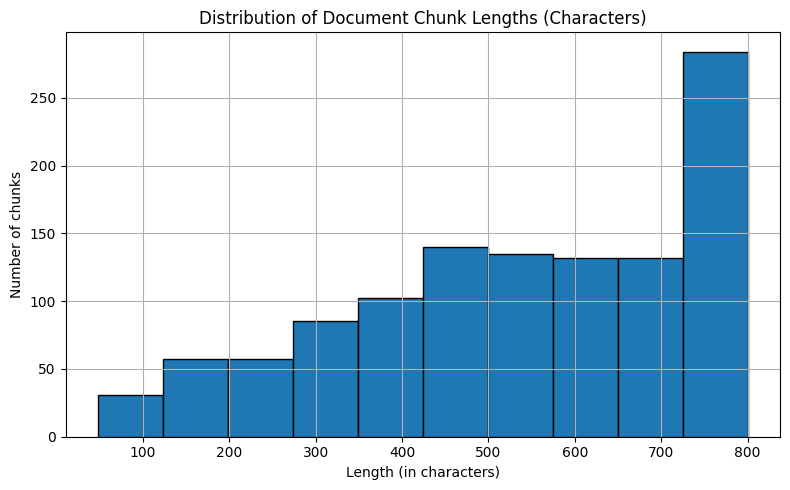

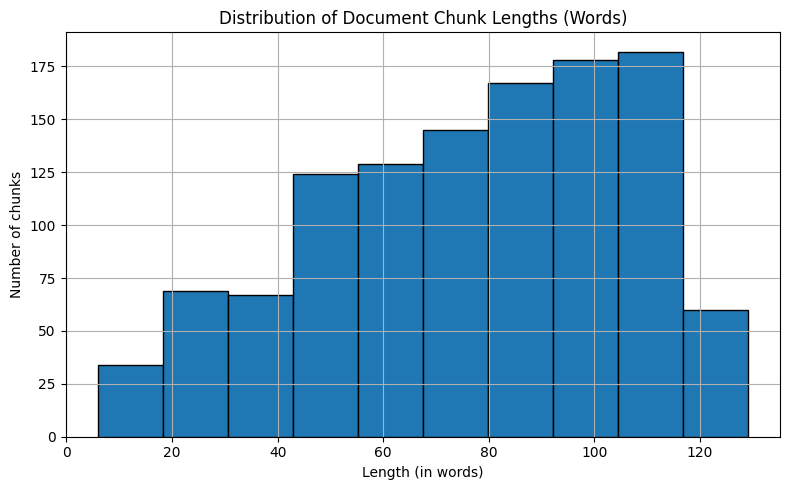

In [ ]:
get_average_chunk_length(chunked_content)
get_average_word_count(chunked_content)
plot_chunk_lengths(chunked_content)
plot_chunk_word_counts(chunked_content)

In [ ]:
# Save extracted content to a text file
output_text_path = "./shef_dcs_extracted_data.txt"
with open(output_text_path, "w", encoding="utf-8") as f:
    for doc in docs_list:
        f.write(f"Content:\n{doc.page_content}\n")
print(f"Data saved to {output_text_path}")

Data saved to ./shef_dcs_extracted_data.txt


In [ ]:
#hf embeddings:
embedding_model_name ="nomic-ai/nomic-embed-text-v1.5"
retriever_model = embedding_model_name

model_kwargs = {'device': 'cuda', 'trust_remote_code': True}
encode_kwargs = {'normalize_embeddings': True}

# Create the HuggingFaceEmbeddings object configuration
hf = HuggingFaceEmbeddings(
    model_name=embedding_model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)


In [ ]:
# use Chroma vector database
vectorstore = Chroma.from_documents(
    documents=chunked_content,
    collection_name="rag-chroma",
    embedding=hf,
    persist_directory="chroma_db"
)

In [ ]:

#hybrid retrieval : BM25 captures exact keyword matches + chroma captures semantic meaning
bm25_retriever = BM25Retriever.from_documents(
    chunked_content
)
bm25_retriever.k = 10

chroma_retriever = vectorstore.as_retriever(
    search_type = "similarity",
    search_kwargs={"k": 10}    #number of docs to retrieve
)

# initialize the ensemble retriever
retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, chroma_retriever], weights=[0.5, 0.5]
)



In [ ]:
#create a reranker
reranker = FlagReranker('BAAI/bge-reranker-v2-m3', use_fp16=True) # Setting use_fp16 to True to speed up computation

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/795 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

In [ ]:
def web_search(question):
    """Performs a web search using the TavilySearchResults tool and retrieves the top k results.

    Args:
        question (str): The query string to search for.

    Returns:
        list: A list containing a single string where the retrieved web results are concatenated with newline separators.

    Function Details:
    - Uses the TavilySearchResults tool to fetch the top 3 search results (`k=3`).
    - Extracts the content from each retrieved document.
    - Joins the content of all retrieved documents into a single string, separated by newlines.
    - Returns the concatenated results inside a list.
    """

    web_search_tool = TavilySearchResults(k=3)
    docs = web_search_tool.invoke({"query": question})
    # web_results = "\n".join([d["content"] for d in docs])
    return [doc["content"] for doc in docs[:2]]

In [ ]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [ ]:
# rewriting_llm= ChatOllama(model="llama3.2:3b-instruct-fp16",
#                  temperature=0.2,
#                  num_predict= 2048,)

# def rewrite_query(query):
#     """re write user query """

#     query_rewrite_instructions ="""You are an AI assistant tasked with reformulating user queries related to research, computer science, computer science departement at Sheffield University to improve retrieval in a RAG system.
#     Given the original query, rewrite it to be more specific, detailed,  and likely to retrieve relevant information.


#     """
#     query_rewrite_prompt = """Here is the original query:{question}.

#     Generate Only one query without mentioning any explanations.

#     Rewritten query:
#     """

#     # Format the prompt with actual data
#     query_rewrite_prompt_formatted = query_rewrite_prompt.format(
#         question=query
#     )

#     result = rewriting_llm.invoke(
#         [SystemMessage(content=query_rewrite_instructions)]
#         + [HumanMessage(content=query_rewrite_prompt_formatted)]
#     )

#     return result.content

In [ ]:
def retrieval_grader(query, retrieved_documents):
    """Evaluates the relevance of retrieved documents using an LLM grader (score 0-5)."""

    doc_grader_instructions = """You are an expert evaluator assessing how relevant a set of retrieved documents are for answering a user's question.

    ## Scoring Guidelines - Assign a relevance score from 0 to 5-based on the following criteria:
    - 5: All documents are highly relevant and clearly help answer the question directly.
    - 4: Most documents are helpful, but 1 may be only somewhat related.
    - 3: Some documents are somewhat relevant, but others are off-topic or vague.
    - 2: Only one document seems weakly related; the rest are irrelevant or noisy.
    - 1: All documents are irrelevant or entirely unrelated to the question.
    - 0: The documents are completely unrelated or confusing or No retrieved documents found at all

    Return JSON with a single key 'relevance_score' containing an integer from 0 to 5.
    """

    doc_grader_prompt = """Here is the user question:\n {question}\n.

    Here is the retrieved document: \n{retrieved_documents} \n

    Be Hard on assessing the relevance of the documents to the question

    Return JSON with a single key 'relevance_score' containing a value from 0 to 5.
    """

    # Format the prompt with actual data
    doc_grader_prompt_formatted = doc_grader_prompt.format(
        retrieved_documents=retrieved_documents, question=query
    )

    result = llm_json_mode.invoke(
        [SystemMessage(content=doc_grader_instructions)]
        + [HumanMessage(content=doc_grader_prompt_formatted)]
    )

    return json.loads(result.content)

In [ ]:
def hallucination_grader(question, facts , generated_answer):
    """Evaluates the factual accuracy of a generated answer based on retrieved documents (hallucination score 1-3)."""

    hallucination_grader_instructions = """
    You are a fact-checking expert evaluating whether an AI-generated response is factually grounded in the provided FACTS.

    **Grading Scale (Hallucination Level):**
    - `1`: Severe Hallucination → The response contains **major inaccuracies** or is **mostly made up**.
    - `2`: Moderate Hallucination → The response is **partially correct** but contains **some inaccuracies**.
    - `3`: No Hallucination → The response is **fully supported** by the provided FACTS.

    **Explanation:**
    - Reference **specific parts of the FACTS** that support or contradict the response.
    - Detail **why you assigned the given hallucination score**.
    - Identify **any false or misleading statements** in the generated response.

    **Your response should be in JSON format:**
    {{
        "hallucination_score": (1-3),
        "explanation": "Detailed reasoning for the score."
    }}
    """

    hallucination_grader_prompt = f"""

    #Question:
    {question}

    ### FACTS:
    {facts}

    ### AI-Generated Answer:
    {generated_answer}

    **Return a JSON response with `hallucination_score` (1-3) and `explanation`.**
    """

    # Invoke the LLM to grade hallucinations
    result = llm_json_mode.invoke(
        [SystemMessage(content=hallucination_grader_instructions)]
        + [HumanMessage(content=hallucination_grader_prompt)]
    )

    try:
        # Attempt to parse JSON
        return json.loads(result.content)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        print("LLM response:", result.content)  # Print problematic response
        return {"hallucination_score": 0, "explanation": "Error parsing JSON response from LLM."} #returning default values when it fails to decode LLM output

In [ ]:

def response_quality_evaluator(question, generated_answer, expected_answer):
    """Evaluates response quality based on Coherence, Fluency, and Relevance using an LLM grader (scores 1-5)."""

    evaluation_prompt = f"""
    You are an evaluator assessing the quality of an AI-generated response based on three key criteria:

    **Coherence (Logical Flow and Sense-Making)**
    - **5 (Excellent):** The response is perfectly coherent, well-organized, and easy to follow. Ideas connect seamlessly with no confusion.
    - **4 (Good):** The response is clear and logical with only minor flaws in coherence or flow. The information is well-structured.
    - **3 (Acceptable):** The response generally makes sense but may have minor logical gaps or require extra effort to understand.
    - **2 (Fair):** The response shows some logic, but the ideas are poorly organized or difficult to follow. Key points may be missing or muddled.
    - **1 (Poor):** The response is completely incoherent, illogical, or nonsensical. The text is confusing and fails to convey any meaningful information.

    **Fluency (Language Clarity and Naturalness)**
    - **5 (Excellent):** The language is highly fluent, natural, and engaging. The text is polished and professional.
    - **4 (Good):** The language is fluent and natural with few or no grammatical issues. The text reads smoothly.
    - **3 (Acceptable):** The language is mostly clear, but some awkward phrasing or minor errors are present.
    - **2 (Fair):** The language is somewhat unnatural or has notable grammatical errors. The response is hard to read in some parts.
    - **1 (Poor):** The language is awkward, unnatural, or difficult to read. Multiple grammatical errors severely hinder comprehension.

    **Relevance (Alignment with User's Query)**
    - **5 (Excellent):** The response is fully relevant, highly informative, and directly addresses the query with precision.
    - **4 (Good):** The response is relevant, accurate, and adequately detailed. Minor improvements may enhance precision.
    - **3 (Acceptable):** The response is mostly relevant but may omit key details or include minor irrelevant content.
    - **2 (Fair):** The response is only partially relevant, with significant off-topic content or inaccuracies.
    - **1 (Poor):** The response is completely irrelevant or unrelated to the query. It provides no useful information.

    ---

    ### Question:
    {question}

    ### Expected Answer:
    {expected_answer}

    ### AI-Generated Answer:
    {generated_answer}

    ### **Your Task:**
    Carefully evaluate the AI-generated answer **based on the above criteria** use the expected answer as a comparison answer. Assign a **numerical score (1-5)** for each category.

    **Provide a JSON response with the following structure:**
    {{
        "coherence": (1-5),
        "fluency": (1-5),
        "relevance": (1-5)
    }}
    """

    # Invoke the LLM to grade the response
    result = llm_json_mode.invoke(
        [SystemMessage(content="You are an expert evaluator.")]+
        [HumanMessage(content=evaluation_prompt)]
    )

    return json.loads(result.content)  # Convert LLM response into dictionary

In [ ]:

def answer_grader(question, generated_answer, expected_answer, retrieved_docs=None):
    """Grades the generated answer on a scale of 1 to 5 based on correctness and hallucinations."""

    answer_grader_instructions = """You are a grader assessing the accuracy of a generated answer to a user question.

    **Grading Criteria (Score from 1 to 5):**
    - `5`: Fully correct, no hallucinations, and complete.
    - `4`: Mostly correct, minor inaccuracies but still relevant.
    - `3`: Partially correct, some key facts missing or slightly incorrect.
    - `2`: Incorrect or contains significant hallucinations.
    - `1`: Completely wrong or entirely made up.

    **Considerations:**
    - Compare the generated answer to the expected answer.
    - If retrieved documents are provided, ensure the generated answer is supported by them.
    - Flag hallucinations if the answer includes details **not present in the retrieved documents**.
    - If the generated answer does not answer the question or say I dont know you should give it a low score.

    **Return a JSON object with:**
    - `answer_score`: An integer from 1 to 5.
    - `explanation`: A brief justification for the score.
    """

    # retrieved_texts = [doc.page_content if hasattr(doc, 'page_content') else str(doc) for doc in retrieved_docs]
    retrieved_context = "\n\n".join(retrieved_docs) if retrieved_docs else "No retrieved documents provided."

    answer_grader_prompt = f"""QUESTION: \n\n{question}\n\n
    EXPECTED ANSWER: \n\n{expected_answer}\n\n
    GENERATED ANSWER: \n\n{generated_answer}\n\n
    RETRIEVED DOCUMENTS:\n\n{retrieved_context}\n\n

    **Return a JSON object with `answer_score` (1-5) and `explanation` fields.**"""

    result = llm_json_mode.invoke(
        [SystemMessage(content=answer_grader_instructions)]
        + [HumanMessage(content=answer_grader_prompt)]
    )

    return json.loads(result.content)

In [ ]:

def answer_review(question, generated_answer, retrieved_context=None):
    """Grades the generated answer on a scale of 1 to 5 based on correctness and hallucinations."""

    answer_grader_instructions = """You are a grader assessing the accuracy and coherence of the generated answer.

    **Grading Criteria (Score from 1 to 5):**
    - `5`: Fully correct, no hallucinations, and perfectly complete and well-organized.
    - `4`: Mostly correct answer, minor inaccuracies but still relevant, clear and logical with only minor flaws in coherence .
    - `3`: Partially correct does not answer all the question, some key facts missing or slightly incorrect.
    - `2`: Incorrect or contains significant hallucinations and the ideas are poorly organized or difficult to follow.
    - `1`: Completely wrong or entirely made up and incoherent, illogical, or nonsensical.

    **Considerations:**
    - give low score if the generated answer is not relevant to the question.
    - give low score if the generated answer is NOt supported by the retrieved documents.
    - give a low score if the generated answer DOES NOT answer the question.

    **Return a JSON object with:**
    - `answer_score`: An integer from 1 to 5.
    - `explanation`: A brief justification for the score.
    """

    answer_grader_prompt = f"""QUESTION: \n\n{question}\n\n
    GENERATED ANSWER: \n\n{generated_answer}\n\n
    RETRIEVED DOCUMENTS:\n\n{retrieved_context}\n\n

    **Return a JSON object with `answer_score` (1-5) and `explanation` fields.**"""

    result = llm_json_mode.invoke(
        [SystemMessage(content=answer_grader_instructions)]
        + [HumanMessage(content=answer_grader_prompt)]
    )

    return json.loads(result.content)

In [ ]:
def refine_answer(question, retrieved_docs, generated_answer):
    """
    Reviews and rewrites a generated answer based on the question and retrieved context.
    Ensures the rewritten answer is accurate, context-grounded, and more fluent.
    """

    review_and_rewrite_instructions = """
You are an assistant that improves chatbot answers by first evaluating the answer for correctness and relevancy,
and then rewriting it using the RETRIEVED CONTEXT given to be more accurate, answer the whole question,fluent, and coherent.

### Your job:
1. Make sure the answer addresses the question based ONLY on the retrieved context.
2. If the answer is incorrect, incomplete, or unrelated, revise it using only the context given.
3. If the answer is correct, rephrase it to improve fluency, structure, and clarity.
4. NEVER introduce information that is not present in the context.

### Output format:
Return JUST the revised answer as plain text
"""

    prompt = f"""QUESTION:
{question}

GENERATED ANSWER:
{generated_answer}

RETRIEVED CONTEXT:
{retrieved_docs}

### Output format:
Return ONLY the revised answer as plain text.
"""

    result = llm.invoke(
        [SystemMessage(content=review_and_rewrite_instructions)] +
        [HumanMessage(content=prompt)]
    )

    return result.content

In [ ]:
# Define Retrieval Function
def retrieve_context(question):
    """
    Retrieves relevant context for the given question.
    """

    try:
      #Retrieve documents based on the question
      docs = retriever.get_relevant_documents(question)
      #no documents retrieved return empty string
      if (len(docs) == 0 ):
          print("unable to find matching documents")
          return ""

      #Rerank retrieved documents based on their relevance score - >= threshold(score=0.5)
      scores = [reranker.compute_score([question, doc.page_content], normalize=True)[0] for doc in docs]
      ranked_docs = sorted(zip(docs, scores), key=lambda x: x[1], reverse=True)
      print(f"scores : {ranked_docs}")
      filtered_docs = [doc for doc, score in ranked_docs if score>0.2]

      # Keep only the top 3 high-scoring documents
      return filtered_docs[:3]
    except:
      print("unable to find matching documents")
      return ""

In [ ]:
#format docs to one string seperated by new lines
def format_docs(docs):
    return "\n\n".join(f"{doc.page_content}\nSource: {doc.metadata.get('source', 'Unknown')}" for doc in docs),"\n\n".join(doc.page_content for doc in docs)

def generate_answer_llama(question , docs):
  #Prompt used to generate answer
  rag_prompt = """You are an assistant for answering questions about research and computer science at the university of Sheffield . Answer the user's question based **only** on the provided context. Please follow the instructions:

  ### Instructions:
  - Answer the question based on the given context.

  - Answer the question in a natural coherent way.

  - Provide a **clear, precise, and complete** answer to the question without additional explanations and information.

  - Ensure your response is **well-structured and informative**.

  - Make sure to use all the context that is relevant to the question.


  ##Context: {context}

  ##Question: {question}

  ##Answer:"""

  docs_txt_with_sources,docs_txt = format_docs(docs)
  #template the prompt with the docs and asked question
  rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
  #Ask the LLM
  generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)]).content
  rephrased_answer = refine_answer(question , docs_txt , generation)
  return rephrased_answer , docs_txt, docs_txt_with_sources



In [ ]:
#Handle general questions, without using RAG pipeline

GENERAL_QUESTIONS = {
    r"hi+i*|hey+|hola+": "Hello! How can I assist you today?",
    r"hello+": "Hi there! What can I help you with?",
    r"how are you\s*\??": "I'm just a bot, but I'm here to help!",
    r"who are you\s*\??": "I am an AI assistant designed to answer questions about research at the University of Sheffield.",
    r"what can you do\s*\??": "I can answer research-related questions about the University of Sheffield. Feel free to ask!"
}

def is_general_question(question: str):
    """Check if the input question is a general query and return a response if it is."""
    question_lower = question.lower().strip()

    # Check if the question matches a predefined response
    for key, response in GENERAL_QUESTIONS.items():
        if re.match(rf"\b{key}\b", question_lower):
            return response

    return None  # Not a general question



In [ ]:

def process_input( question):
    """Retrieves documents, generates an answer"""
    # Check for general questions first. return answer without using RAG pipeline
    general_response = is_general_question(question)
    if general_response is not None:
        return general_response, "No documents retrieved."

    # Retrieve Documents
    retrieved_docs = retrieve_context(question)

    if (len(retrieved_docs) == 0 ):
        return (
            "I'm a chatbot designed to answer questions about the University of Sheffield. "
            "Please ask a relevant question related to this topic.",
            "No documents retrieved."
        )

    rag_output, retrieved_txt , docs_with_sources = generate_answer_llama(question, retrieved_docs)
    # review = answer_review(question, rag_output, retrieved_txt)
    # answer_score = review["answer_score"]
    # expl = review["explanation"]
    # print(f" ********* answer score {answer_score}")
    # print(f" ******    explanation of the answer score:: {expl} \n")

    # if(answer_score < 4):
    #   print(f"inside if condition generated answer is : {rag_output}")
    #   return (
    #       "I’m a chatbot designed to answer questions about research in the Department of Computer Science at the University of Sheffield."
    #       " Please ask a relevant question related to this topic.",
    #       "No documents retrieved."
    #       )

    # print(f"ANSWER BEFORE REFINING : \n {rag_output}")
    # rephrased_answer = refine_answer(question , retrieved_txt , rag_output)
    # print(f"ANSWER AFTER REFINING : \n {rephrased_answer}")

    return rag_output,docs_with_sources

In [ ]:
# Function to process user input and return response for the UI
def process_input_gradio_ui( message , history ):
    """Processes the user's question using the RAG system and returns only the latest response."""

    # Call your RAG processing function
    rag_response ,docs_with_sources= process_input(message)
    if (len(rag_response) == 0 ):
      return  ("I’m a chatbot designed to answer questions about research in the Department of Computer Science at the University of Sheffield."
                " Please ask a relevant question related to this topic.",
                "No Documents retrieved")

    # Stream response word by word
    response_text = ""
    for word in rag_response.split():
        response_text += word + " "
        yield response_text, docs_with_sources  # Stream the update
        time.sleep(0.05)  # Simulate streaming delay


# Create Gradio UI
with gr.Blocks() as demo:
    gr.Markdown(" <center><h1>🔍 University of Sheffield Assistant</h1></center>")


    # Define the Accordion for displaying retrieved documents
    with gr.Accordion("📄 Show Retrieved Documents", open=False):
        retrieved_docs_output = gr.Markdown()

    # Initialize the ChatInterface with additional outputs
    chat_interface = gr.ChatInterface(
        fn=process_input_gradio_ui,stop_btn=True,
        additional_outputs=[retrieved_docs_output],
        type="messages",autoscroll = True,editable=True,
        save_history=True
    )


# Launch the Gradio UI
demo.launch(share=True, debug=True)


# 📊 **Comprehensive Evaluation of RAG Chatbot vs. Baseline Models**

## 🔍 **Purpose**
This evaluation framework provides a rigorous and multifaceted assessment of a **Retrieval-Augmented Generation (RAG) chatbot** compared to several baseline models. The goal is to evaluate both **retrieval effectiveness** and **answer generation quality**, using a set of **105 manually prepared test questions and reference answers**.

---

## 🧪 **Evaluation Phases**

The pipeline is divided into **three major evaluation phases**:

---

### 🔹 **1. Document Retrieval Evaluation**

**Goal:** Evaluate how well each method retrieves relevant information for a given query.

**Retrieval Methods Compared:**
- **RAG Retrieval System**: Combines vector-based retrieval (Chroma), BM25, and a reranking model.
- **TF-IDF Retrieval**: Classic sparse retrieval baseline.
- **BM25 Retrieval**: Keyword-based statistical baseline.

**Metrics:**
- **Relevance Score (0–5):** Rated by an LLM grader based on alignment with query intent.
- **Hit Rate (Score ≥ 4):** Proportion of queries with high-quality document matches.
- **Retrieval Time:** Time required to fetch the documents.

**Outputs:**
- Scores and logs written to `/content/retrieval_scores_result.txt`
- **Contrastive Judgments** by an LLM comparing RAG vs. TF-IDF retrieval (stored in `/content/retrieval_comparison_results.txt`)
- Visual comparisons via bar charts

---

### 🔹 **2. Answer Generation Evaluation**

**Goal:** Evaluate the quality of answers generated by different models using retrieved or external data.

**Models Evaluated:**
- **RAG Chatbot**: Uses hybrid retrieval and a LLaMA 3.2-based generation.
- **LLM Only**: LLaMA 3.2 answering without retrieval context.
- **Web Search Chatbot**: Leverages external web search results.
- **TF-IDF + LLM**: Combines basic retrieval with the same LLM.

**Metrics:**
- **Answer Score (1–5):** Measures overall correctness and completeness.
- **Coherence Score (1–5):** Evaluates clarity and logical flow.
- **Fluency Score (1–5):** Measures grammar and readability.
- **Relevance Score (1–5):** Assesses topical alignment with the question.
- **Hallucination Score (1–3):** Indicates factual accuracy (3 = no hallucination).
- **Answer Time:** Duration taken to generate a response.

**Outputs:**
- Detailed logs in `/content/answer_scores_result.txt`
- Coherence, fluency, relevance scores in `/content/chatbot_quality_score.txt`
- Hallucination evaluation results in `/content/hallucination_score.txt`

---

### 🔹 **3. Automated RAG Evaluation with RAGAS**

**Goal:** Use standardized RAG metrics to perform structured evaluation of retrieved context and generated answers.

**Datasets Evaluated:**
- **RAG Chatbot**
- **TF-IDF + LLM**
- **Web Search Chatbot**
- **LLM-Only**

**Metrics Used:**
- `context_recall`
- `faithfulness`
- `factual_correctness (F1)`
- `context_precision_with_reference`
- `context_precision_without_reference`

**Outputs:**
- Results saved as `.json` and loaded into RAGAS
- Evaluation summaries printed and plotted

---

## 📊 **Visualization**

### 🔸 Retrieval Evaluation
- 📊 **Bar Charts**: Average relevance score, hit rate (score ≥ 4), and retrieval time per method
- 🤖 **Contrastive LLM Judgments**: Count of times RAG vs. TF-IDF was preferred

### 🔸 Answer Evaluation
- 📊 **Bar Charts**: Average answer score, coherence, fluency, relevance, hallucination
- ⚡ **Answer Time** comparison across models
- 🎯 **Hit Rates** (Score ≥ 4) breakdown by metric

### 🔸 Hallucination Analysis
- 📉 **Average hallucination scores**
- 📊 **Score distribution histograms** per model

---

## 🗂 **Evaluation Artifacts**

- 📄 `/content/retrieval_scores_result.txt` – Relevance scores and retrieved docs  
- 📄 `/content/retrieval_comparison_results.txt` – LLM judgments comparing retrieval systems  
- 📄 `/content/answer_scores_result.txt` – Answer scores for each model  
- 📄 `/content/chatbot_quality_score.txt` – Fluency, coherence, and relevance logs  
- 📄 `/content/hallucination_score.txt` – Hallucination scores and rationales  
- 📁 `*.json` files – Formatted input for RAGAS (e.g., `RAG_chat_data.json`, etc.)

---


In [ ]:
## read the questions:
with open("/content/questions.txt") as file:
  evaluation_questions=[line.strip() for line in file.readlines() ]
## read the answers:
with open("/content/answers.txt") as file:
  expected_answers=[line.strip() for line in file.readlines() ]

In [ ]:
len(evaluation_questions)

104

In [ ]:
# Simple function to answer a question using a LLM llama3.2:3b - Base Line model to compare with RAG chatbot
def simple_llama_answer(question):
  return llm.invoke([HumanMessage(content=question)]).content

In [ ]:
def chatbot_web_search_docs(question):

  web_search_docs = web_search(question)
  # Handle the case where no web search results are found
  if not web_search_docs or web_search_docs == [""]:
      return "I'm sorry, but I couldn't find relevant information from the web search.", "No web search documents found."

  rag_prompt = """You are an excellent assistant for answering questions about research and computer science at the university of Sheffield . Answer the user's question based **only** on the provided context.

  ##Here is the context to use to answer the question. Read it attentively and use it:
  {context}

  ##Question:
  {question}

  ##Answer:"""


  #template the prompt with the docs and asked question
  rag_prompt_formatted = rag_prompt.format(context=web_search_docs, question=question)

  #Ask the LLM
  generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)]).content


  return generation , web_search_docs

In [ ]:
#### create tfidf retriever as a base line model to compare it with my retriever system
def tfidf_docs_retriever(question):
  tfidf_retriever = TFIDFRetriever.from_documents(chunked_content)
  tfidf_retriever.k = 3
  return tfidf_retriever.invoke(question)

In [ ]:
#### create bm25 retriever as a base line model to compare it with my retriever system
def bm25_docs_retriever(question):
  bm25_retriever = BM25Retriever.from_documents(chunked_content)
  bm25_retriever.k = 3
  return bm25_retriever.invoke(question)


In [ ]:
## this one retrieves documents using TFIDF

def simple_generate_answer_llama(question):
  #Prompt used to generate answer
  rag_prompt = """You are an assistant for answering questions about research and computer science at the university of Sheffield . Answer the user's question based **only** on the provided context.

  ##Context: {context}

  ##Question: {question}

  ##Answer:"""

  docs = tfidf_docs_retriever(question)
  formatted_docs = "\n".join(doc.page_content for doc in docs)
  #template the prompt with the docs and asked question
  rag_prompt_formatted = rag_prompt.format(context=formatted_docs, question=question)
  #Ask the LLM
  generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)]).content

  return generation, formatted_docs

In [ ]:
### Evaluate retrieval system ###

RAG_retrieval_times = []
RAG_retrieval_score = []
tfidf_retrieval_times = []
tfidf_retrieval_score = []
bm25_retrieval_times = []
bm25_retrieval_score = []
ALL_RAG_retrieved_docs_STRING = []
ALL_RAG_retrieved_docs_LIST = []
ALL_TFIDF_retrieved_docs_STRING = []
ALL_BM25_retrieved_docs_STRING = []

output_file= "/content/retrieval_scores_result.txt"
with open(output_file , "a" , encoding="utf-8") as f:
  for question in tqdm(evaluation_questions, desc="Processing Questions", unit="qst"):

    #eval RAG retrieval system
    RAG_retrieval_start_time = time.time()
    RAG_retrieved_docs = retrieve_context(question)
    RAG_retrieval_times.append(time.time() - RAG_retrieval_start_time)
    ALL_RAG_retrieved_docs_LIST.append([doc.page_content for doc in RAG_retrieved_docs])
    formatted_docs = "\n".join(doc.page_content for doc in RAG_retrieved_docs)
    ALL_RAG_retrieved_docs_STRING.append(formatted_docs)

    #eval simple TF-IDF retrieval system
    tfidf_retrieval_start_time = time.time()
    tfidf_retrieved_docs = tfidf_docs_retriever(question)
    tfidf_retrieval_times.append(time.time() - tfidf_retrieval_start_time)
    formatted_docs = "\n".join(doc.page_content for doc in tfidf_retrieved_docs)
    ALL_TFIDF_retrieved_docs_STRING.append(formatted_docs)

    #eval simple BM25 retrieval system
    bm25_retrieval_start_time = time.time()
    bm25_retrieved_docs = bm25_docs_retriever(question)
    bm25_retrieval_times.append(time.time() - bm25_retrieval_start_time)
    formatted_docs = "\n".join(doc.page_content for doc in tfidf_retrieved_docs)
    ALL_BM25_retrieved_docs_STRING.append(formatted_docs)

    ## score all three docs at once.
    RAG_formatted_docs = "\n\n".join([doc.page_content for doc in RAG_retrieved_docs])  # Format retrieved docs
    tfidf_formatted_docs = "\n\n".join([doc.page_content for doc in tfidf_retrieved_docs])
    bm25_formatted_docs = "\n\n".join([doc.page_content for doc in bm25_retrieved_docs])

    # Calculate the relevance scores
    RAG_relevance_score = retrieval_grader(question, RAG_formatted_docs)["relevance_score"]
    tfidf_relevance_score = retrieval_grader(question, tfidf_formatted_docs)["relevance_score"]
    bm25_relevance_score = retrieval_grader(question, bm25_formatted_docs)["relevance_score"]



    ## write to the result file:
    f.write(f"Question: {question}\n")
    f.write(f"RAG relevance Score: {RAG_relevance_score}\n")
    f.write(f"TF-IDF relevance Score: {tfidf_relevance_score}\n")
    f.write(f"BM25 relevance Score: {bm25_relevance_score}\n")
    f.write(f"RAG retrieved Documents:\n{RAG_formatted_docs}\n")
    f.write(f"TF-IDF retrieved Documents:\n{tfidf_formatted_docs}\n")
    f.write(f"BM25 retrieved Documents:\n{bm25_formatted_docs}\n")
    f.write("=" * 80 + "\n")  # Separator

    RAG_retrieval_score.append(RAG_relevance_score)
    tfidf_retrieval_score.append(tfidf_relevance_score)
    bm25_retrieval_score.append(bm25_relevance_score)

Processing Questions: 100%|██████████| 104/104 [03:10<00:00,  1.83s/qst]


In [ ]:
#### CALCULATE EVALUATION METRICS FOR RETRIEVAL (Both tf-idf and RAG chatbot). ####

## Average retrieval score
#RAG
RAG_average_retrieval_score = sum(RAG_retrieval_score) / len(RAG_retrieval_score)
print(f"Average RAG Retrieval Score: {RAG_average_retrieval_score}")
#tfidf
tfidf_average_retrieval_score = sum(tfidf_retrieval_score) / len(tfidf_retrieval_score)
print(f"Average TF-IDF Retrieval Score: {tfidf_average_retrieval_score}")
#BM25
bm25_average_retrieval_score = sum(bm25_retrieval_score) / len(bm25_retrieval_score)
print(f"Average BM25 Retrieval Score: {bm25_average_retrieval_score}")

## SCORE DISTRIBUTION
#RAG
RAG_score_distribution = collections.Counter(RAG_retrieval_score)
print("Score Distribution - RAG retrieval system:", RAG_score_distribution)
#tfidf
tfidf_score_distribution = collections.Counter(tfidf_retrieval_score)
print("Score Distribution - TF-IDF retrieval system:", tfidf_score_distribution)
#BM25
bm25_score_distribution = collections.Counter(bm25_retrieval_score)
print("Score Distribution - BM25 retrieval system:", bm25_score_distribution)

## CALCULATE HIT RATE >=4 :
#RAG
RAG_hit_rate = sum(1 for s in RAG_retrieval_score if s >= 4) / len(RAG_retrieval_score)
print(f"Hit Rate (Score ≥ 4) -- RAG --: {RAG_hit_rate:.2%}")
#tfidf
tfidf_hit_rate = sum(1 for s in tfidf_retrieval_score if s >= 4) / len(tfidf_retrieval_score)
print(f"Hit Rate (Score ≥ 4) -- TF-IDF --: {tfidf_hit_rate:.2%}")
#BM25
bm25_hit_rate = sum(1 for s in bm25_retrieval_score if s >= 4) / len(bm25_retrieval_score)
print(f"Hit Rate (Score ≥ 4) -- BM25 --: {bm25_hit_rate:.2%}")

## CALCULATE AVERAGE TIME TAKEN FOR RETRIEVING THE DOCS :
#RAG
RAG_average_retrieval_time = sum(RAG_retrieval_times) / len(RAG_retrieval_times)
print(f"Average Retrieval Time -- RAG --: {RAG_average_retrieval_time:.2f} seconds")
#tfidf
tfidf_average_retrieval_time = sum(tfidf_retrieval_times) / len(tfidf_retrieval_times)
print(f"Average Retrieval Time -- TF-IDF --: {tfidf_average_retrieval_time:.2f} seconds")
#BM25
bm25_average_retrieval_time = sum(bm25_retrieval_times) / len(bm25_retrieval_times)
print(f"Average Retrieval Time -- BM25 --: {bm25_average_retrieval_time:.2f} seconds")

Average RAG Retrieval Score: 3.0096153846153846
Average TF-IDF Retrieval Score: 2.625
Average BM25 Retrieval Score: 2.125
Score Distribution - RAG retrieval system: Counter({4: 45, 2: 34, 1: 13, 5: 8, 3: 4})
Score Distribution - TF-IDF retrieval system: Counter({4: 38, 2: 31, 1: 27, 3: 4, 5: 4})
Score Distribution - BM25 retrieval system: Counter({1: 44, 2: 31, 4: 22, 3: 4, 5: 3})
Hit Rate (Score ≥ 4) -- RAG --: 50.96%
Hit Rate (Score ≥ 4) -- TF-IDF --: 40.38%
Hit Rate (Score ≥ 4) -- BM25 --: 24.04%
Average Retrieval Time -- RAG --: 0.76 seconds
Average Retrieval Time -- TF-IDF --: 0.08 seconds
Average Retrieval Time -- BM25 --: 0.05 seconds


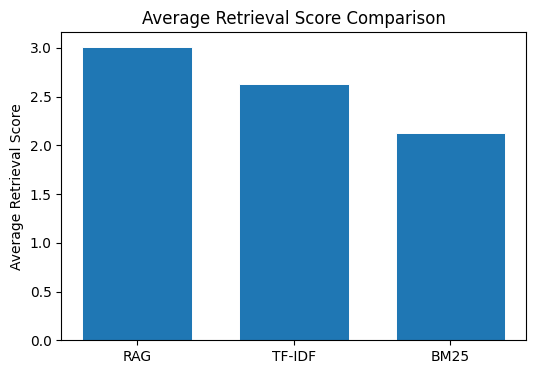

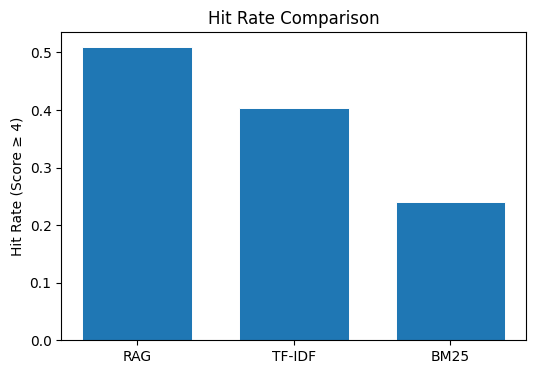

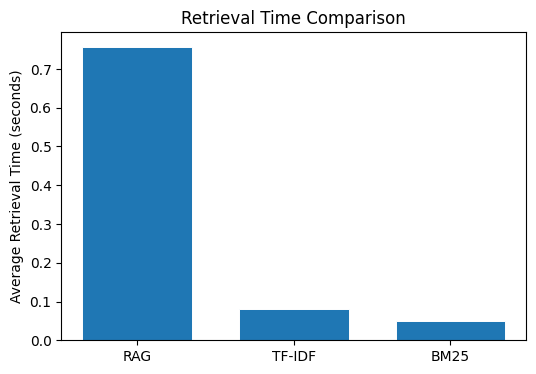

In [ ]:
### plot graphs for retrieval evaluation ###

# Bar chart for average retrieval scores
plt.figure(figsize=(6, 4))
plt.bar(["RAG", "TF-IDF","BM25"], [RAG_average_retrieval_score, tfidf_average_retrieval_score,bm25_average_retrieval_score],width =0.7 , edgecolor="white", linewidth=0.7)
plt.ylabel("Average Retrieval Score")
plt.title("Average Retrieval Score Comparison")
plt.show()

# Bar chart for hit rates
plt.figure(figsize=(6, 4))
plt.bar(["RAG", "TF-IDF","BM25"], [RAG_hit_rate, tfidf_hit_rate,bm25_hit_rate], width=0.7 , edgecolor="white", linewidth=0.7)
plt.ylabel("Hit Rate (Score ≥ 4)")
plt.title("Hit Rate Comparison")
plt.show()

# Bar chart for average retrieval times
plt.figure(figsize=(6, 4))
plt.bar(["RAG", "TF-IDF","BM25"], [RAG_average_retrieval_time, tfidf_average_retrieval_time,bm25_average_retrieval_time] , width=0.7 , edgecolor="white", linewidth=0.7)
plt.ylabel("Average Retrieval Time (seconds)")
plt.title("Retrieval Time Comparison")
plt.show()


In [ ]:

def contrastive_retrieval_eval_basic(question, docs_a, docs_b):

  sys_prompt = """
  You are an expert evaluator tasked with comparing two retrieval methods based on how relevant their retrieved documents are to a given question. Only consider document relevance to the question. Ignore writing style or fluency..

  Your goal is to determine which method retrieved documents that are more helpful for answering the question, based **only on relevance**.

  ---

  ### Evaluation Guidelines:

  - Assess **only** how relevant the retrieved documents are to the user's question.
  - Ignore writing style, formatting, or fluency.
  - Consider whether the documents directly contain **useful, specific, or factual information** that would help answer the question.
  - Penalize methods that return off-topic, generic, or vague content.
  - Favor documents that clearly address the **core intent** of the question.
  ---
  ### Scoring Instructions:

  Carefully compare the two methods. Then respond with:

  ```json
  {
    "better_method": "A" or "B",
    "explanation": "A brief explanation of why one set of documents was more relevant."
  }
  """
  answer_grader_prompt = """
  QUESTION:
  {question}

  ---

  ### Documents retrieved by Method A (RAG-based retrieval):
  {docs_a}

  ---

  ### Documents retrieved by Method B (TF-IDF-based retrieval):
  {docs_b}


  """
  doc_grader_prompt_formatted = answer_grader_prompt.format(
      docs_a=docs_a, question=question,docs_b=docs_b
  )
  result = llm_json_mode.invoke(
      [SystemMessage(content=sys_prompt)]
      + [HumanMessage(content=doc_grader_prompt_formatted)]
  )

  return json.loads(result.content)

In [ ]:
results = []
output_file= "/content/retrieval_comparison_results.txt"
with open(output_file , "a" , encoding="utf-8") as f:
  for question in tqdm(evaluation_questions, desc="Processing Questions", unit="qst"):
    #eval RAG retrieval system
    RAG_retrieved_docs = retrieve_context(question)

    #eval simple TF-IDF retrieval system
    tfidf_retrieved_docs = tfidf_docs_retriever(question)

    # Format retrieved docs
    RAG_formatted_docs = "\n".join([doc.page_content for doc in RAG_retrieved_docs])
    tfidf_formatted_docs = "\n".join([doc.page_content for doc in tfidf_retrieved_docs])

    best_method = contrastive_retrieval_eval_basic(question, RAG_formatted_docs, tfidf_formatted_docs)["better_method"]
    explanation = contrastive_retrieval_eval_basic(question, RAG_formatted_docs, tfidf_formatted_docs)["explanation"]

    results.append(best_method)

    #write to the result file
    f.write(f"- Question: {question}\n")
    f.write(f"-- Best Method: {best_method}\n")
    f.write(f"--- Explanation: {explanation}\n")
    f.write("=" * 80)

Processing Questions: 100%|██████████| 104/104 [05:29<00:00,  3.17s/qst]


Count of RAG method retrieval: 97
Count of TFIDF method retrieval: 7
 -------- 


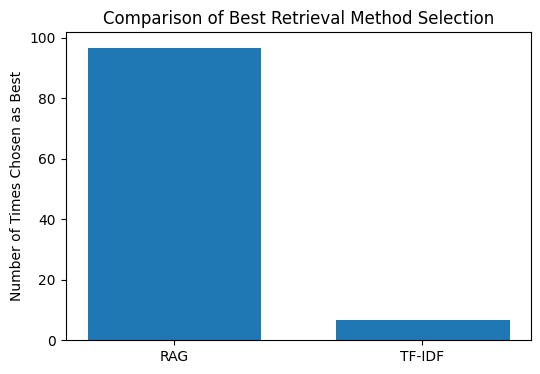

In [ ]:
count = Counter(results)

RAG_method_count = count['A']
TFIDF_method_count = count['B']

print("Count of RAG method retrieval:", RAG_method_count)
print("Count of TFIDF method retrieval:", TFIDF_method_count)
print(" -------- ")
# Bar chart for Best method
plt.figure(figsize=(6, 4))
plt.bar(["RAG", "TF-IDF"], [RAG_method_count, TFIDF_method_count],width =0.7 , edgecolor="white", linewidth=0.7)
plt.ylabel("Number of Times Chosen as Best")
plt.title("Comparison of Best Retrieval Method Selection")
plt.show()

In [ ]:
### Evaluate answers generated by RAG chatbot and other RAGs ###
#time
RAG_answer_times = []
LLM_answer_times = []
web_search_answer_times = []
#score
RAG_answer_score = []
LLM_answer_score = []
web_seaerch_chatbot_score = []
#answers
RAGs_answer = []
LLM_answer = []
web_search_answers = []
ALL_web_search_docs = []

tfidf_llama_answer = []
tfidf_llama_docs = []

output_file = "/content/answer_scores_result.txt"
with open(output_file, "a", encoding="utf-8") as f:
    for i in tqdm(range(len(evaluation_questions)), desc="Processing Questions", unit="question"):
        retrieved_docs = retrieve_context(evaluation_questions[i])

        # Eval RAG chatbot answers
        RAG_start_time = time.time()
        rag_output, retrieved_docs, x = generate_answer_llama(evaluation_questions[i], retrieved_docs)
        RAG_answer_times.append(time.time() - RAG_start_time)
        RAGs_answer.append(rag_output) # append all answers to use in ragas

        # Eval simple llama3.2 model answers (base model) - no retrieved docs
        LLM_start_time = time.time()
        simple_llm_response = simple_llama_answer(evaluation_questions[i])
        LLM_answer_times.append(time.time() - LLM_start_time)
        LLM_answer.append(simple_llm_response) # append all answers to use in ragas

        # Eval RAG using web search documents + llama
        web_search_start_time = time.time()
        web_search_chatbot_response, chatbot_web_search_retr_docs = chatbot_web_search_docs(evaluation_questions[i])
        web_search_answer_times.append(time.time() - web_search_start_time)
        ALL_web_search_docs.append(chatbot_web_search_retr_docs)
        web_search_answers.append(web_search_chatbot_response) # append all answers to use in ragas

        # Eval RAG: TF-IDF + llama
        simple_llama , simpel_docs = simple_generate_answer_llama(evaluation_questions[i])
        tfidf_llama_answer.append(simple_llama)
        tfidf_llama_docs.append(simpel_docs)

        # Answer grader
        RAG_answer = answer_grader(evaluation_questions[i], rag_output, expected_answers[i], retrieved_docs)
        llama_answer = answer_grader(evaluation_questions[i], simple_llm_response, expected_answers[i])
        web_search_answer = answer_grader(evaluation_questions[i], web_search_chatbot_response, expected_answers[i])

        # Write to the result file
        f.write(f"Question: {evaluation_questions[i]}\n")
        f.write(f"Generated answer by the Chatbot:\n{rag_output}\n")
        f.write(f"Generated answer by Llama 3.2 model:\n{simple_llm_response}\n")
        f.write(f"Generated answer by the Chatbot using web search:\n{web_search_chatbot_response}\n")
        f.write(f"Expected answer:\n{expected_answers[i]}\n")
        f.write(f"Chatbot answer Score: {RAG_answer}\n")
        f.write(f"Llama 3.2 answer Score: {llama_answer}\n")
        f.write(f"Chatbot using web search answer Score: {web_search_answer}\n")
        f.write("=" * 80 + "\n")  # Separator

        LLM_answer_score.append(llama_answer['answer_score'])
        RAG_answer_score.append(RAG_answer['answer_score'])
        web_seaerch_chatbot_score.append(web_search_answer['answer_score'])

Processing Questions: 100%|██████████| 104/104 [22:28<00:00, 12.97s/question]


In [ ]:
## ragas
import pandas as pd
#prepare data

## first db: rag system answers and retrieved docs
RAG_data = [{"user_input": query, "response": response , "retrieved_contexts":[retrieved_d] , "reference": ground_truth} for query, response, retrieved_d, ground_truth in zip(evaluation_questions, RAGs_answer,ALL_RAG_retrieved_docs_STRING,expected_answers)]

## second db: web search chatbot answers and retrieved docs
WEB_search_data = [{"user_input": query, "response": response , "retrieved_contexts":retrieved_d , "reference": ground_truth} for query, response, retrieved_d, ground_truth in zip(evaluation_questions, web_search_answers ,ALL_web_search_docs,expected_answers )]

## Third db: LLM + TFIDF RAG
tfidf_RAG = [{"user_input": query, "response": response , "retrieved_contexts":[retrieved_d] , "reference": ground_truth} for query, response, retrieved_d, ground_truth in zip(evaluation_questions, tfidf_llama_answer ,tfidf_llama_docs , expected_answers )]

# Fourth db: no retrieved docs Just LLM response
LLM_data = [{"user_input": query, "response": response  , "reference": ground_truth} for query, response, ground_truth in zip(evaluation_questions, LLM_answer,expected_answers)]

RAG_df = pd.DataFrame(RAG_data)
WEB_df = pd.DataFrame(WEB_search_data)
tfidf_RAG_df = pd.DataFrame(tfidf_RAG)
LLM_data_df = pd.DataFrame(LLM_data)



# Write to a JSON file
with open("/content/RAG_chat_data.json", "w", encoding="utf-8") as f:
    json.dump(RAG_data, f, ensure_ascii=False, indent=4)
with open("/content/web_search_chat_data.json", "w", encoding="utf-8") as f:
    json.dump(WEB_search_data, f, ensure_ascii=False, indent=4)
with open("/content/tfidf_RAG_data.json", "w", encoding="utf-8") as f:
    json.dump(tfidf_RAG, f, ensure_ascii=False, indent=4)
with open("/content/LLM_data.json", "w", encoding="utf-8") as f:
    json.dump(LLM_data, f, ensure_ascii=False, indent=4)


In [ ]:
!ollama pull llama3:8b


In [ ]:
!ollama list

NAME                         ID              SIZE      MODIFIED    
llama3:8b                    365c0bd3c000    4.7 GB    2 hours ago    
llama3.2:3b-instruct-fp16    195a8c01d91e    6.4 GB    2 hours ago    


In [ ]:
from ragas import EvaluationDataset
RAG_evaluation_dataset = EvaluationDataset.from_list(RAG_data)
tfidf_evaluation_dataset = EvaluationDataset.from_list(tfidf_RAG)
WEB_evaluation_dataset = EvaluationDataset.from_list(WEB_search_data)
LLM_no_docs_dataset = EvaluationDataset.from_list(LLM_data)

llm_ragas = ChatOllama(model="llama3:8b",
                           temperature=0.2,
                           device_map='cuda')

from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.metrics import (LLMContextRecall, Faithfulness,
                           FactualCorrectness,ResponseRelevancy,
                           LLMContextPrecisionWithReference,LLMContextPrecisionWithoutReference)


evaluator_llm = LangchainLLMWrapper(llm_ragas)

RAG_result = evaluate(
    dataset=RAG_evaluation_dataset,
    metrics=[LLMContextRecall(),Faithfulness(),FactualCorrectness(),LLMContextPrecisionWithReference(),LLMContextPrecisionWithoutReference()],
    llm=evaluator_llm,
)



In [ ]:
# context_recall	faithfulness	factual_correctness(mode=f1)	llm_context_precision_with_reference	llm_context_precision_without_reference
context_recall = RAG_result.to_pandas()['context_recall'].tolist()
faithfulness = RAG_result.to_pandas()['faithfulness'].tolist()
factual_correctness = RAG_result.to_pandas()['factual_correctness(mode=f1)'].tolist()  # mode='f1' assumed default
llm_context_precision_with_reference = RAG_result.to_pandas()['llm_context_precision_with_reference'].tolist()
llm_context_precision_without_reference = RAG_result.to_pandas()['llm_context_precision_without_reference'].tolist()

In [ ]:
print(f"context recall rag : {context_recall}")
print(f"faithfulness rag : {faithfulness}")
print(f"factual_correctness rag : {factual_correctness}")
print(f"llm_context_precision_with_reference rag : {llm_context_precision_with_reference}")
print(f"llm_context_precision_without_reference rag : {llm_context_precision_without_reference}")

context recall rag : [1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.6, 0.5, 0.6666666666666666, 1.0, 1.0, 0.5, 1.0, 0.25, 1.0, 1.0, 0.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5, 1.0, 0.3333333333333333, 1.0, 1.0, 0.5, 0.0, 0.6666666666666666, 0.8, 1.0, 1.0, 0.5, 0.5, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.6666666666666666, 0.5, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, nan, 0.5, 0.6666666666666666, 1.0, 1.0, 0.6666666666666666, 0.5, 0.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.6666666666666666]
faithfulness rag : [1.0, 1.0, 1.0, 0.8, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.75, 0.8, 1.0, 0.3333333333333333, 1.0, nan, 1.0, 1.0, 0.7, 0.9090909090909091, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.888888

In [ ]:
tfidf_RAG_result = evaluate(
    dataset=tfidf_evaluation_dataset,
    metrics=[LLMContextRecall(),Faithfulness(),FactualCorrectness(),LLMContextPrecisionWithReference(),LLMContextPrecisionWithoutReference()],
    llm=evaluator_llm,
)



In [ ]:
context_recall_tfidf = tfidf_RAG_result.to_pandas()['context_recall'].tolist()
faithfulness_tfidf  = tfidf_RAG_result.to_pandas()['faithfulness'].tolist()
factual_correctness_tfidf  = tfidf_RAG_result.to_pandas()['factual_correctness(mode=f1)'].tolist()  # mode='f1' assumed default
llm_context_precision_with_reference_tfidf  = tfidf_RAG_result.to_pandas()['llm_context_precision_with_reference'].tolist()
llm_context_precision_without_reference_tfidf  = tfidf_RAG_result.to_pandas()['llm_context_precision_without_reference'].tolist()

In [ ]:
print("context_recall_tfidf:", context_recall_tfidf)
print("faithfulness_tfidf:", faithfulness_tfidf)
print("factual_correctness_tfidf:", factual_correctness_tfidf)
print("llm_context_precision_with_reference_tfidf:", llm_context_precision_with_reference_tfidf)
print("llm_context_precision_without_reference_tfidf:", llm_context_precision_without_reference_tfidf)

context_recall_tfidf: [1.0, 0.5, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, nan, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.25, 1.0, 0.6666666666666666, 0.5, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.75, 0.3333333333333333, 1.0, 0.0, 0.5, 1.0, 0.5, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.5, 1.0, 1.0, 0.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.2, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.5, 0.6666666666666666, 0.0, 0.3333333333333333, 0.3333333333333333, 1.0, nan, 0.5, 0.5, 1.0, 0.5, 1.0, 0.0, 0.5]
faithfulness_tfidf: [1.0, 1.0, 0.5, 1.0, 0.5, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, nan, 0.0, 0.75, 0.5, 0.75, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 0.75, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.8571428571428571, 1.0, 1.0, 1.0, 0.5,

In [ ]:
WEB_result = evaluate(
    dataset=WEB_evaluation_dataset,
    metrics=[LLMContextRecall(),Faithfulness(),FactualCorrectness(),LLMContextPrecisionWithReference(),LLMContextPrecisionWithoutReference()],
    llm=evaluator_llm,
)


In [ ]:
WEB_result

{'context_recall': 0.7337, 'faithfulness': 0.8722, 'factual_correctness(mode=f1)': 0.4372, 'llm_context_precision_with_reference': 0.7740, 'llm_context_precision_without_reference': 0.8510}

In [ ]:
# Extract metrics from WEB_result
context_recall_web = WEB_result.to_pandas()['context_recall'].tolist()
faithfulness_web = WEB_result.to_pandas()['faithfulness'].tolist()
factual_correctness_web = WEB_result.to_pandas()['factual_correctness(mode=f1)'].tolist()
llm_context_precision_with_reference_web = WEB_result.to_pandas()['llm_context_precision_with_reference'].tolist()
llm_context_precision_without_reference_web = WEB_result.to_pandas()['llm_context_precision_without_reference'].tolist()

# Print each list
print("context_recall_web:", context_recall_web)
print("faithfulness_web:", faithfulness_web)
print("factual_correctness_web:", factual_correctness_web)
print("llm_context_precision_with_reference_web:", llm_context_precision_with_reference_web)
print("llm_context_precision_without_reference_web:", llm_context_precision_without_reference_web)

context_recall_web: [1.0, 1.0, 1.0, 1.0, 1.0, nan, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.5, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.3333333333333333, 0.0, 1.0, nan, 1.0, 1.0, 0.5, 0.6, 0.0, 1.0, 0.6666666666666666, 0.5, 1.0, 0.75, 0.3333333333333333, 0.25, nan, 1.0, nan, 1.0, 1.0, 0.5, 1.0, 0.5, 0.4, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.0, 1.0, 0.5, 1.0, 0.8, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.6, 0.5, 1.0, 0.0, nan, 0.5, 1.0, 1.0, 1.0, 0.75, 0.75, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, nan, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 0.6666666666666666, 0.6, 0.0, 1.0, 1.0, 0.5, 1.0, 0.5, 0.0, nan, 1.0, 1.0, 0.6666666666666666]
faithfulness_web: [1.0, 1.0, 0.25, 1.0, 0.5, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0.3333333333333333, 0.75, 1.0, 1.0, 1.0, 0.875, 0.8333333333333334, 1.0, 1.0, nan, 0.8571428571428571, 0.75, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8181818181818182, 1.0, 0.25, 1.0, 1.0, 0.6666666666666666, 0.75, 0.8, 1.0, 0.8, 1.0

In [ ]:
LLM_no_docs_result = evaluate(
    dataset=LLM_no_docs_dataset,
    metrics=[FactualCorrectness()],
    llm=evaluator_llm,
)

In [ ]:
LLM_no_docs_result

{'factual_correctness(mode=f1)': 0.3530}

In [ ]:
# Extract metrics from LLM_no_docs_result
factual_correctness_llm_no_docs = LLM_no_docs_result.to_pandas()['factual_correctness(mode=f1)'].tolist()


# Print each list
print("factual_correctness_llm_no_docs:", factual_correctness_llm_no_docs)


factual_correctness_llm_no_docs: [nan, 0.0, 0.0, 0.0, nan, 0.0, 0.5, 0.0, 0.0, 0.22, 0.0, 0.0, 0.5, 0.4, 0.0, 0.0, 0.0, 0.71, 0.18, 0.8, nan, 0.42, nan, 0.0, 0.0, 0.4, 0.4, 0.0, 0.89, 0.89, nan, 0.5, nan, nan, nan, nan, 0.56, nan, 0.9, nan, 0.89, 0.0, 0.0, 0.4, 0.0, 0.0, 0.63, 0.0, 0.0, 0.67, 0.57, nan, 0.86, 0.22, 0.0, 0.92, nan, nan, 0.0, 0.0, 0.29, 0.96, 0.6, 0.31, 0.63, 0.18, nan, nan, 0.62, 0.29, 0.29, 0.0, 0.43, 0.86, 0.0, 0.0, 0.0, 0.33, 0.46, 0.8, 0.6, 0.0, 0.29, 0.0, 0.0, 0.0, 0.67, 0.74, 0.53, 0.75, 0.54, nan, 0.57, nan, nan, 0.33, 0.2, 0.43, 0.93, 0.73, nan, 0.75, nan, 0.76]


In [ ]:
# print(f"RAG Result: {RAG_result}")
# print(" -------- ")
# print(f"TF-IDF RAG Result: {tfidf_RAG_result}")
# print(" -------- ")
# print(f"WEB Result: {WEB_result}")
# print(" -------- ")
# print(f"LLM Result: {LLM_no_docs_result}")

RAG Result: {'context_recall': 1.0000, 'faithfulness': 1.0000, 'factual_correctness(mode=f1)': 0.4000, 'llm_context_precision_with_reference': 1.0000, 'llm_context_precision_without_reference': 1.0000}
 -------- 
TF-IDF RAG Result: {'context_recall': 1.0000, 'faithfulness': 1.0000, 'factual_correctness(mode=f1)': 0.4000, 'llm_context_precision_with_reference': 1.0000, 'llm_context_precision_without_reference': 1.0000}
 -------- 
WEB Result: {'context_recall': 1.0000, 'faithfulness': 1.0000, 'factual_correctness(mode=f1)': 0.2000, 'llm_context_precision_with_reference': 1.0000, 'llm_context_precision_without_reference': 1.0000}
 -------- 
LLM Result: {'factual_correctness(mode=f1)': 0.0000}


In [ ]:
## CALCULATE EVALUATION METRICS FOR ANSWERING

####  CALCULATE AVERAGE ANSWER SCORE:
#Chatbot
Chatbot_average_answer_score = sum(RAG_answer_score) / len(RAG_answer_score)
print(f"Average Answer Score: {Chatbot_average_answer_score}")
#llama
LLM_average_answer_score = sum(LLM_answer_score) / len(LLM_answer_score)
print(f"Average Answer Score: {LLM_average_answer_score}")
#web_search
web_search_average_answer_score = sum(web_seaerch_chatbot_score) / len(web_seaerch_chatbot_score)
print(f"Average Answer Score: {web_search_average_answer_score}")
print(" -------- ")

####  CALCULATE ANSWERS SCORE DISTRIBUTION :
#Chatbot
Chatbot_score_distribution = collections.Counter(RAG_answer_score)
print("Chatbot score Distribution:", Chatbot_score_distribution)
#llama
LLM_score_distribution = collections.Counter(LLM_answer_score)
print("LLM score Distribution:", LLM_score_distribution)
#web_search
web_search_score_distribution = collections.Counter(web_seaerch_chatbot_score)
print("web_search score Distribution:", web_search_score_distribution)
print(" -------- ")

####  CALCULATE HIT RATE >=4 :
#chatbot
chatbot_hit_rate = sum(1 for s in RAG_answer_score if s >= 4) / len(RAG_answer_score)
print(f"Chatbot Hit Rate (Score ≥ 4): {chatbot_hit_rate:.2%}")
#llama
llm_hit_rate = sum(1 for s in LLM_answer_score if s >= 4) / len(LLM_answer_score)
print(f"LLM Hit Rate (Score ≥ 4): {llm_hit_rate:.2%}")
#web_search
web_search_hit_rate = sum(1 for s in web_seaerch_chatbot_score if s >= 4) / len(web_seaerch_chatbot_score)
print(f"Chatbot using web search Hit Rate (Score ≥ 4): {web_search_hit_rate:.2%}")
print(" -------- ")
####  CALCULATE AVERAGE TIME TAKEN FOR ANSWERING :
#chatbot
chatbot_avg_time = sum(RAG_answer_times) / len(RAG_answer_times)
print(f"Chatbot average Answer Time: {chatbot_avg_time:.2f} seconds")
#llama
llm_avg_time = sum(LLM_answer_times) / len(LLM_answer_times)
print(f"LLM average Answer Time: {llm_avg_time:.2f} seconds")
#web_search
web_search_avg_time = sum(web_search_answer_times) / len(web_search_answer_times)
print(f"Chatbot using web search average Answer Time: {web_search_avg_time:.2f} seconds")


Average Answer Score: 3.7788461538461537
Average Answer Score: 2.6538461538461537
Average Answer Score: 2.8365384615384617
 -------- 
Chatbot score Distribution: Counter({4: 90, 3: 11, 0: 3})
LLM score Distribution: Counter({2: 65, 4: 33, 1: 3, 3: 2, 5: 1})
web_search score Distribution: Counter({2: 61, 4: 36, 5: 4, 3: 3})
 -------- 
Chatbot Hit Rate (Score ≥ 4): 86.54%
LLM Hit Rate (Score ≥ 4): 32.69%
Chatbot using web search Hit Rate (Score ≥ 4): 38.46%
 -------- 
Chatbot average Answer Time: 1.74 seconds
LLM average Answer Time: 2.16 seconds
Chatbot using web search average Answer Time: 4.52 seconds


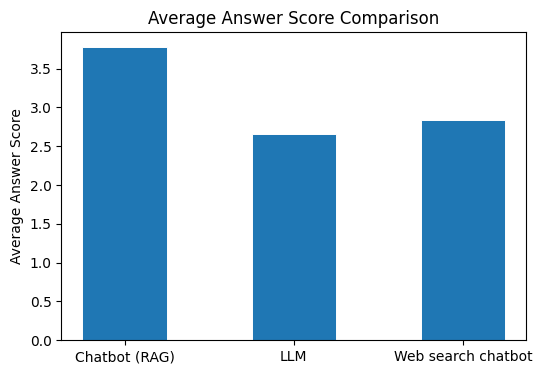

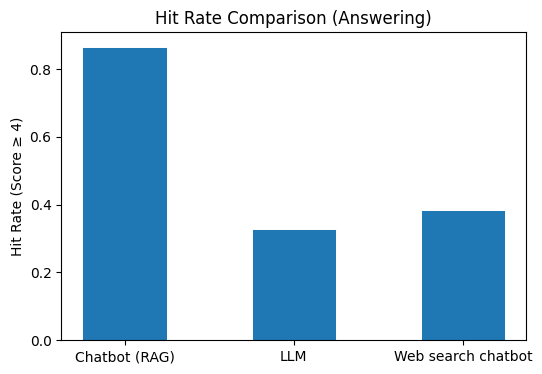

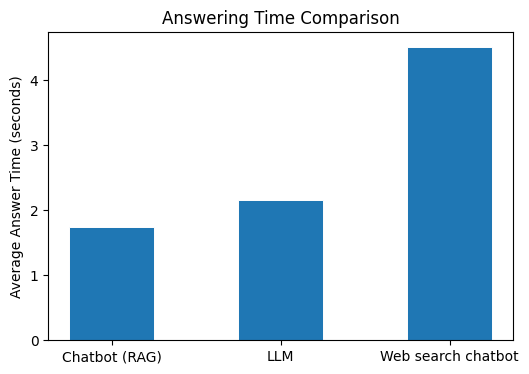

In [ ]:
### plot graphs for answer evaluation ###

# Bar chart for average answer scores
plt.figure(figsize=(6, 4))
plt.bar(["Chatbot (RAG)", "LLM", "Web search chatbot"], [Chatbot_average_answer_score, LLM_average_answer_score,web_search_average_answer_score], width=0.5, edgecolor="white", linewidth=0.7)
plt.ylabel("Average Answer Score")
plt.title("Average Answer Score Comparison")
plt.show()

# Bar chart for hit rates
plt.figure(figsize=(6, 4))
plt.bar(["Chatbot (RAG)", "LLM","Web search chatbot"], [chatbot_hit_rate, llm_hit_rate,web_search_hit_rate] , width=0.5 , edgecolor="white", linewidth=0.7)
plt.ylabel("Hit Rate (Score ≥ 4)")
plt.title("Hit Rate Comparison (Answering)")
plt.show()

# Bar chart for average answering times
plt.figure(figsize=(6, 4))
plt.bar(["Chatbot (RAG)", "LLM","Web search chatbot"], [chatbot_avg_time, llm_avg_time,web_search_avg_time], width=0.5 , edgecolor="white", linewidth=0.7)
plt.ylabel("Average Answer Time (seconds)")
plt.title("Answering Time Comparison")
plt.show()


In [ ]:
### Evaluate answers generated by RAG chatbot, simple llm, and a web search based chatbot, based on "coherence","relevance", and "fluency" ###


RAG_answer_coherence = []
RAG_answer_relevance = []
RAG_answer_fluency = []
llm_answer_coherence = []
llm_answer_relevance = []
llm_answer_fluency = []
web_search_answer_coherence = []
web_search_answer_relevance = []
web_search_answer_fluency = []

output_file = "/content/chatbot_quality_score.txt"
with open(output_file, "a", encoding="utf-8") as f:
    for i in tqdm(range(len(evaluation_questions)), desc="Processing Questions", unit="question"):

        # Eval RAG chatbot answers
        retrieved_docs = retrieve_context(evaluation_questions[i])
        rag_output, retrieved_docs,x = generate_answer_llama(evaluation_questions[i], retrieved_docs)

        # Eval simple llama3.2 model answers (base model)
        simple_llm_response = simple_llama_answer(evaluation_questions[i])

        # Eval web search chatbot
        web_search_chatbot_response = chatbot_web_search_docs(evaluation_questions[i])


        RAG_answer_quality = response_quality_evaluator(evaluation_questions[i], rag_output, expected_answers[i])
        llama_answer_quality = response_quality_evaluator(evaluation_questions[i], simple_llm_response, expected_answers[i])
        web_search_answer_quality = response_quality_evaluator(evaluation_questions[i], web_search_chatbot_response, expected_answers[i])

        # Write to the result file
        f.write(f"Question: {evaluation_questions[i]}\n")
        f.write(f"---> Chatbot answer quality score : {RAG_answer_quality}\n")
        f.write(f"---> LLM answer quality score : {llama_answer_quality}\n")
        f.write(f"---> Chatbot using web search answer quality score : {web_search_answer_quality}\n")
        f.write("=" * 80 + "\n")  # Separator

        RAG_answer_coherence.append(RAG_answer_quality['coherence'])
        RAG_answer_relevance.append(RAG_answer_quality['relevance'])
        RAG_answer_fluency.append(RAG_answer_quality['fluency'])
        llm_answer_coherence.append(llama_answer_quality['coherence'])
        llm_answer_relevance.append(llama_answer_quality['relevance'])
        llm_answer_fluency.append(llama_answer_quality['fluency'])
        web_search_answer_coherence.append(web_search_answer_quality['coherence'])
        web_search_answer_relevance.append(web_search_answer_quality['relevance'])
        web_search_answer_fluency.append(web_search_answer_quality['fluency'])


Processing Questions: 100%|██████████| 104/104 [17:20<00:00, 10.00s/question]


In [ ]:
# Calculate the average coherence, relevance, and fluency scores
rag_average_coherence = sum(RAG_answer_coherence) / len(RAG_answer_coherence)
rag_average_relevance = sum(RAG_answer_relevance) / len(RAG_answer_relevance)
rag_average_fluency = sum(RAG_answer_fluency) / len(RAG_answer_fluency)
llm_average_coherence = sum(llm_answer_coherence) / len(llm_answer_coherence)
llm_average_relevance = sum(llm_answer_relevance) / len(llm_answer_relevance)
llm_average_fluency = sum(llm_answer_fluency) / len(llm_answer_fluency)
web_search_avg_coherence = sum(web_search_answer_coherence) / len(web_search_answer_coherence)
web_search_avg_relevance = sum(web_search_answer_relevance) / len(web_search_answer_relevance)
web_search_avg_fluency = sum(web_search_answer_fluency) / len(web_search_answer_fluency)


print(f"RAG Average Coherence: {rag_average_coherence:.2f}")
print(f"LLM Average Coherence: {llm_average_coherence:.2f}")
print(f"Chatbot using web search Average Coherence: {web_search_avg_coherence:.2f}\n")
print(" -------- ")
print(f"RAG Average Relevance: {rag_average_relevance:.2f}")
print(f"LLM Average Relevance: {llm_average_relevance:.2f}")
print(f"Chatbot using web search Average Relevance: {web_search_avg_relevance:.2f}\n")
print(" -------- ")
print(f"RAG Average Fluency: {rag_average_fluency:.2f}")
print(f"LLM Average Fluency: {llm_average_fluency:.2f}")
print(f"Chatbot using web search Average Fluency: {web_search_avg_fluency:.2f}\n")

# Calculate Hit Rate (Score ≥ 4) for each metric
rag_hit_rate_coherence = sum(1 for s in RAG_answer_coherence if s >= 4) / len(RAG_answer_coherence)
rag_hit_rate_relevance = sum(1 for s in RAG_answer_relevance if s >= 4) / len(RAG_answer_relevance)
rag_hit_rate_fluency = sum(1 for s in RAG_answer_fluency if s >= 4) / len(RAG_answer_fluency)
llm_hit_rate_coherence = sum(1 for s in llm_answer_coherence if s >= 4) / len(llm_answer_coherence)
llm_hit_rate_relevance = sum(1 for s in llm_answer_relevance if s >= 4) / len(llm_answer_relevance)
llm_hit_rate_fluency = sum(1 for s in llm_answer_fluency if s >= 4) / len(llm_answer_fluency)
web_search_hit_rate_coherence = sum(1 for s in web_search_answer_coherence if s >= 4) / len(web_search_answer_coherence)
web_search_hit_rate_relevance = sum(1 for s in web_search_answer_relevance if s >= 4) / len(web_search_answer_relevance)
web_search_hit_rate_fluency = sum(1 for s in web_search_answer_fluency if s >= 4) / len(web_search_answer_fluency)
print(" -------- ")
print(f"RAG Hit Rate (Score ≥ 4) - Coherence: {rag_hit_rate_coherence:.2%}")
print(f"LLM Hit Rate (Score ≥ 4) - Coherence: {llm_hit_rate_coherence:.2%}")
print(f"Chatbot using web search Hit Rate (Score ≥ 4) - Coherence: {web_search_hit_rate_coherence:.2%}\n")
print(" -------- ")
print(f"RAG Hit Rate (Score ≥ 4) - Relevance: {rag_hit_rate_relevance:.2%}")
print(f"LLM Hit Rate (Score ≥ 4) - Relevance: {llm_hit_rate_relevance:.2%}")
print(f"Chatbot using web search Hit Rate (Score ≥ 4) - Relevance: {web_search_hit_rate_relevance:.2%}\n")
print(" -------- ")
print(f"RAG Hit Rate (Score ≥ 4) - Fluency: {rag_hit_rate_fluency:.2%}")
print(f"LLM Hit Rate (Score ≥ 4) - Fluency: {llm_hit_rate_fluency:.2%}")
print(f"Chatbot using web search Hit Rate (Score ≥ 4) - Fluency: {web_search_hit_rate_fluency:.2%}")


RAG Average Coherence: 3.88
LLM Average Coherence: 3.36
Chatbot using web search Average Coherence: 3.46

 -------- 
RAG Average Relevance: 4.04
LLM Average Relevance: 3.15
Chatbot using web search Average Relevance: 3.72

 -------- 
RAG Average Fluency: 3.35
LLM Average Fluency: 3.19
Chatbot using web search Average Fluency: 2.74

 -------- 
RAG Hit Rate (Score ≥ 4) - Coherence: 90.38%
LLM Hit Rate (Score ≥ 4) - Coherence: 46.15%
Chatbot using web search Hit Rate (Score ≥ 4) - Coherence: 61.54%

 -------- 
RAG Hit Rate (Score ≥ 4) - Relevance: 77.88%
LLM Hit Rate (Score ≥ 4) - Relevance: 49.04%
Chatbot using web search Hit Rate (Score ≥ 4) - Relevance: 71.15%

 -------- 
RAG Hit Rate (Score ≥ 4) - Fluency: 33.65%
LLM Hit Rate (Score ≥ 4) - Fluency: 38.46%
Chatbot using web search Hit Rate (Score ≥ 4) - Fluency: 0.96%


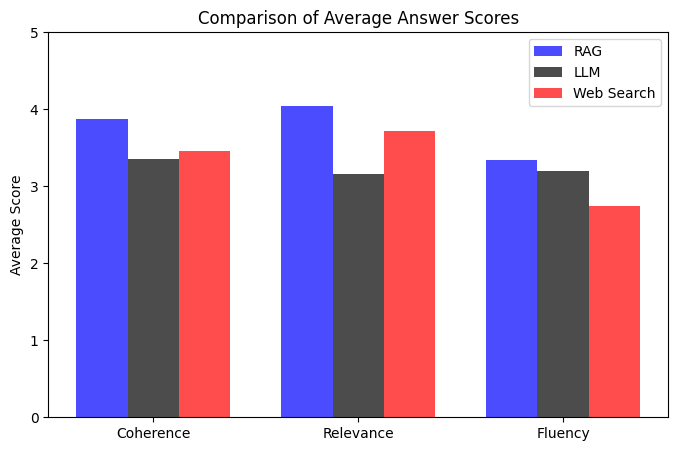

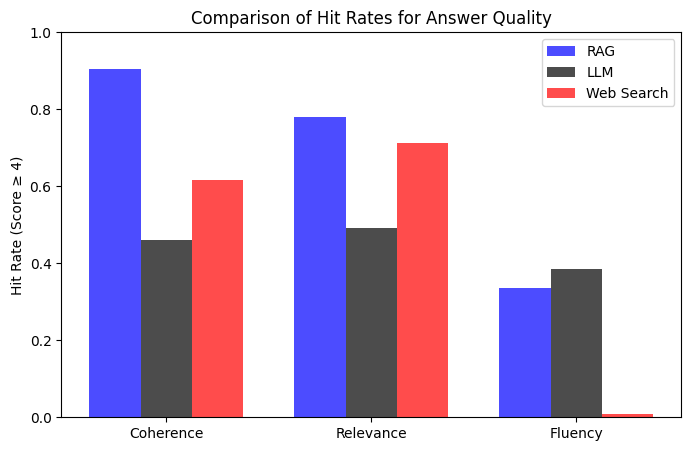

In [ ]:
# Define categories and corresponding scores
categories = ["Coherence", "Relevance", "Fluency"]
models = ["RAG", "LLM", "Web Search"]

# Average Scores for each model
average_scores = np.array([
    [rag_average_coherence, rag_average_relevance, rag_average_fluency],
    [llm_average_coherence, llm_average_relevance, llm_average_fluency],
    [web_search_avg_coherence, web_search_avg_relevance, web_search_avg_fluency]
])

# Hit Rates for each model
hit_rates = np.array([
    [rag_hit_rate_coherence, rag_hit_rate_relevance, rag_hit_rate_fluency],
    [llm_hit_rate_coherence, llm_hit_rate_relevance, llm_hit_rate_fluency],
    [web_search_hit_rate_coherence, web_search_hit_rate_relevance, web_search_hit_rate_fluency]
])

# Define bar positions
x = np.arange(len(categories))
width = 0.25  # Width of bars

# Plot Average Answer Scores
plt.figure(figsize=(8, 5))
plt.bar(x - width, average_scores[0], width, label="RAG", color='blue', alpha=0.7)
plt.bar(x, average_scores[1], width, label="LLM", color='black', alpha=0.7)
plt.bar(x + width, average_scores[2], width, label="Web Search", color='red', alpha=0.7)

plt.xticks(x, categories)
plt.ylabel("Average Score")
plt.title("Comparison of Average Answer Scores")
plt.ylim(0, 5)  # Assuming scores range from 1 to 5
plt.legend()
plt.show()

# Plot Hit Rates
plt.figure(figsize=(8, 5))
plt.bar(x - width, hit_rates[0], width, label="RAG", color='blue', alpha=0.7)
plt.bar(x, hit_rates[1], width, label="LLM", color='black', alpha=0.7)
plt.bar(x + width, hit_rates[2], width, label="Web Search", color='red', alpha=0.7)

plt.xticks(x, categories)
plt.ylabel("Hit Rate (Score ≥ 4)")
plt.title("Comparison of Hit Rates for Answer Quality")
plt.ylim(0, 1)  # Hit rates range from 0 to 1 (percentage format in previous print output)
plt.legend()
plt.show()

In [ ]:
### Evaluate answers by RAG chatbot and simple llm bassed on hallucination ###

RAG_hallucination_score = []
LLM_halllucination_score = []
Web_Search_hallucination_score = []

output_file = "/content/hallucination_score.txt"
with open(output_file, "a", encoding="utf-8") as f:
    for i in tqdm(range(len(evaluation_questions)), desc="Processing Questions", unit="question"):

        # Eval RAG chatbot answers
        retrieved_docs = retrieve_context(evaluation_questions[i])
        rag_output, retrieved_docs,x = generate_answer_llama(evaluation_questions[i], retrieved_docs)

        # Eval simple llama3.2 model answers (base model)
        simple_llm_response = simple_llama_answer(evaluation_questions[i])

        # Eval web search chatbot
        web_search_chatbot_response = chatbot_web_search_docs(evaluation_questions[i])

        RAG_hallucination = hallucination_grader(evaluation_questions[i],retrieved_docs, rag_output)
        llama_hallucination = hallucination_grader(evaluation_questions[i],retrieved_docs, simple_llm_response)
        web_search_hallucination = hallucination_grader(evaluation_questions[i],retrieved_docs, web_search_chatbot_response)

        # Write to the result file
        f.write(f"Question: {evaluation_questions[i]}\n")
        f.write(f"---> Chatbot generated answer: {rag_output}\n")
        f.write(f"Chatbot answer hallucination score : {RAG_hallucination['hallucination_score']}\n")
        f.write(f"Chatbot answer hallucination explanation : {RAG_hallucination['explanation']}\n")
        f.write(f"---> LLM genrated answer: {simple_llm_response}\n")
        f.write(f"LLM answer hallucination score : {llama_hallucination['hallucination_score']}\n")
        f.write(f"LLM answer hallucination explanation : {llama_hallucination['explanation']}\n")
        f.write(f"---> Chatbot using web search generated answer: {web_search_chatbot_response}\n")
        f.write(f"Chatbot using web search answer hallucination score : {web_search_hallucination['hallucination_score']}\n")
        f.write(f"Chatbot using web search answer hallucination explanation : {web_search_hallucination['explanation']}\n")
        f.write("=" * 80 + "\n")  # Separator

        RAG_hallucination_score.append(RAG_hallucination['hallucination_score'])
        LLM_halllucination_score.append(llama_hallucination['hallucination_score'])
        Web_Search_hallucination_score.append(web_search_hallucination['hallucination_score'])

Processing Questions: 100%|██████████| 105/105 [20:29<00:00, 11.71s/question]


In [ ]:
## CALCULATE EVALUATION METRICS FOR ANSWERS HALLUCINATION
#Average Score
rag_average_hallucination_score = sum(RAG_hallucination_score) / len(RAG_hallucination_score)
llm_average_hallucination_score = sum(LLM_halllucination_score) / len(LLM_halllucination_score)
web_search_average_hallucination_score = sum(Web_Search_hallucination_score) / len(Web_Search_hallucination_score)
print(f"RAG Average Hallucination Score: {rag_average_hallucination_score}")
print(f"LLM Average Hallucination Score: {llm_average_hallucination_score}")
print(f"Chatbot using web search Average Hallucination Score: {web_search_average_hallucination_score}\n")
print(" ----- ")
# Score Distribution
rag_hallucination_distribution = collections.Counter(RAG_hallucination_score)
print("\nChatbot score Distribution:", rag_hallucination_distribution)
llm_hallucination_distribution = collections.Counter(LLM_halllucination_score)
print("LLM score Distribution:", llm_hallucination_distribution)
web_search_hallucination_distribution = collections.Counter(Web_Search_hallucination_score)
print("Chatbot using web search score Distribution:", web_search_hallucination_distribution)

RAG Average Hallucination Score: 2.4857142857142858
LLM Average Hallucination Score: 2.0952380952380953
Chatbot using web search Average Hallucination Score: 2.1333333333333333

 ----- 

Chatbot score Distribution: Counter({3: 53, 2: 51, 0: 1})
LLM score Distribution: Counter({2: 87, 3: 14, 1: 4})
Chatbot using web search score Distribution: Counter({2: 81, 3: 19, 1: 5})


In [ ]:
models = ["RAG", "LLM", "Web Search"]

# Average Hallucination Scores
average_hallucination_scores = [
    rag_average_hallucination_score,
    llm_average_hallucination_score,
    web_search_average_hallucination_score
]

# Plot Average Hallucination Scores (Bar Chart)
plt.figure(figsize=(8, 5))
plt.bar(models, average_hallucination_scores, color=['blue', 'black', 'red'], alpha=0.7,width=0.5)
plt.ylabel("Average Hallucination Score")
plt.title("Comparison of Average Hallucination Scores (3:BEST)")
plt.ylim(0, max(average_hallucination_scores) + 0.5)
plt.show()

# Score Distribution - Ensure consistent x-axis values across all models
all_scores = sorted(set(rag_hallucination_distribution.keys()) |
                    set(llm_hallucination_distribution.keys()) |
                    set(web_search_hallucination_distribution.keys()))

rag_values = [rag_hallucination_distribution.get(score, 1) for score in all_scores]
llm_values = [llm_hallucination_distribution.get(score, 1) for score in all_scores]
web_values = [web_search_hallucination_distribution.get(score, 1) for score in all_scores]

# Bar plot for hallucination score distribution
x = np.arange(len(all_scores))  # X-axis positions
width = 0.25  # Width of bars

plt.figure(figsize=(8, 5))
plt.bar(x - width, rag_values, width, label="RAG", color='blue', alpha=0.7)
plt.bar(x, llm_values, width, label="LLM", color='black', alpha=0.7)
plt.bar(x + width, web_values, width, label="Web Search", color='red', alpha=0.7)

plt.xlabel("Hallucination Score")
plt.ylabel("Frequency")
plt.title("Distribution of Hallucination Scores Across Models")
plt.xticks(x, all_scores)  # Set x-axis labels
plt.legend()
plt.show()

---

## 🏆 **Key Findings**
- The **RAG chatbot consistently outperforms baseline retrieval methods (TF-IDF, BM25)** in **relevance and hit rate**.
- **LLM-only answers lack factual accuracy** compared to **RAG-based answers**.
- **Web search retrieval can introduce off-topic information**, reducing coherence and relevance.
- The **hallucination rate is lowest in the RAG chatbot**, confirming that retrieval-grounded responses are **more reliable**.

---

## 🔥 **Future Improvements**
🔹 **Improve retrieval ranking** with **cross-encoder reranking** and other new techniques and technologies.   
🔹 **Enhance factual grounding** using **fact-checking modules**.  
🔹 Add **PDF input** Feature for users.  
🔹 Incorporating **agentic AI principles** using frameworks like LangGraph.<br>
🔹 Question Reformulation.   

---

## 🏁 **Conclusion**
This evaluation framework enables a **deep and systematic analysis** of both retrieval quality and generation performance across RAG and baseline models.  
It highlights the strengths of **retrieval-augmented generation**, especially for applications requiring factual accuracy and relevance, and provides actionable insights for future development.

---
